<h1>DCF77 PSK demodulation</h1>

# Introduction

DCF77 is a timesignal transmitter located in Mainflingen near Frankfurt-am-Main in Germany. It transmits on 77.5 KHz with a transmission-power of 30 KW. <br>
<br>
The timesignal, as described on the website of the <a href="https://www.ptb.de/cms/en/ptb/fachabteilungen/abt4/fb-44/ag-442/dissemination-of-legal-time/dcf77.html">Physikalisch-Technische Bundesanstalt</a>, <a href="https://www.sigidwiki.com/wiki/DCF77">sigidwiki</a> and <a href="https://en.wikipedia.org/wiki/DCF77"> wikipedia</a> contains time information both in AM and in PSK. This notebook deals with decoding the PSK signal.<br>
The Phase-shift keying format of DCF77 is described in detail on the German-language version of the PTB website. Details can be found <a href="https://www.ptb.de/cms/de/ptb/fachabteilungen/abt4/fb-44/ag-442/dissemination-of-legal-time/dcf77/dcf77-phase-modulation.html">here</a> and <a href="https://www.ptb.de/cms/fileadmin/internet/fachabteilungen/abteilung_4/4.4_zeit_und_frequenz/pdf/2004_Piester_-_PTB-Mitteilungen_114.pdf">here</a>.<br>
<br>
In short, the PSK modulation of the timesignal is done by modulating the carrier with plus/minus 15.6 degrees phase-shift during the last 800 ms per second. This PSK modulation carries a fixed 512 bit pseudo-random bitsequence which is 0-to-1 inverted depending on the information bit that is sent.

# Part 1: Preparations
## Loading libraries

In [1]:
import numpy as np
import scipy.signal

import matplotlib.pyplot as plt

from schmitt import schmitt


## Global variables

In [2]:
samp_rate=48000

pi=np.pi # short names
pi2=np.pi*2

## Load I/Q Data

In [3]:
fname="dcf77_30s.f32"

numsec=10 # just load l0 seconds
d=np.fromfile(fname,dtype=np.complex64,offset=0,count=int(samp_rate*numsec))


### Examining the data
Let's make a spectrogram (horizontal waterfall) of the signal<br>

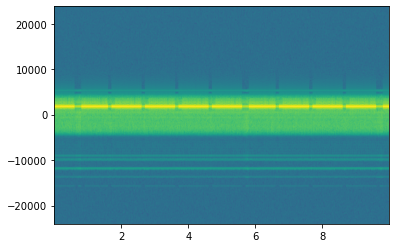

In [4]:

ax = plt.axes()
ax.specgram(d, Fs=48000, scale='dB')
plt.show()



## Frequency correction
We need to do a frequency correction. Let's first determine the frequency offset.<br>As the signal starts from the beginning of the sample-data, we can make a FFT of the very start of the signal and use that as a reference for the complete file.


In [5]:
numbins=2**18
f=np.fft.fftshift(np.fft.fft(d,n=numbins))

maxbin=np.argmax(f.real)

fr=samp_rate*(maxbin/numbins)-(samp_rate/2)
print("frequency:",fr)

frequency: 1800.29296875


### Downconvert to 0 Hz
Generare a tone of minus "frequency-correction" (see above) Hz, mix that with the received signal and plot the result

In [6]:
tone_freq=-fr
tone_t=np.linspace(0,numsec*tone_freq*2*np.pi,int(numsec*samp_rate), endpoint=False)
tone_s=np.cos(tone_t)+np.sin(tone_t)*1j

dmixed=d*tone_s

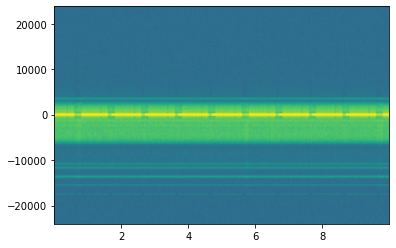

In [7]:
ax = plt.axes()
ax.specgram(dmixed, Fs=48000, scale='dB')
plt.show()

# Part 2: Analysing the signal
Let's take a look at the signal: the signal itself, and the amplitude, frequency and phase.<br>
We will zoom into the first 5 seconds of the data file.

In [8]:
# do AM, Phase and FM demodulation

amdemod=np.abs(dmixed)**2
ph=np.angle(dmixed)

fmdemod=np.diff(ph)
for i in np.where(fmdemod>pi)[0]: fmdemod[i] -= pi2

for i in np.where(fmdemod<-pi)[0]: fmdemod[i] += pi2

t=np.linspace(0,numsec,samp_rate*numsec) # timescale .. used for plotting

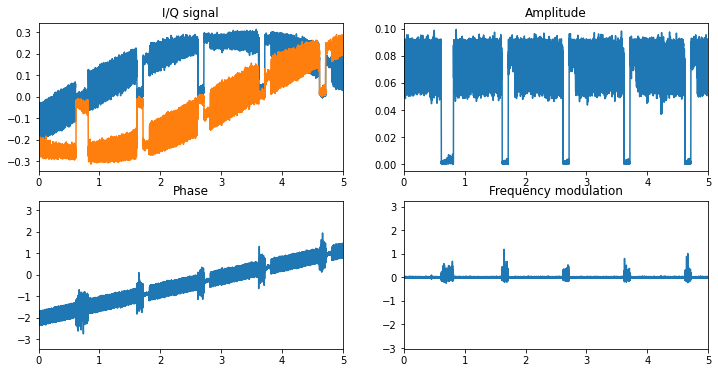

In [9]:
# create the plot

fig, axs = plt.subplots(2, 2)

# the signal itself
trgt=axs[0,0]
trgt.plot(t,dmixed.real)
trgt.plot(t,dmixed.imag)
trgt.set_title("I/Q signal")
trgt.set_xlim(0,5)

# amplitude
trgt=axs[0,1]
trgt.plot(t,amdemod)
trgt.set_title("Amplitude")
trgt.set_xlim(0,5)

# phase
trgt=axs[1,0]
trgt.plot(t,ph) # fm demodulation redunces the number of samples by 1
trgt.set_title("Phase")
trgt.set_xlim(0,5)

# frequency
trgt=axs[1,1]
trgt.plot(t[1:],fmdemod) # fm demodulation redunces the number of samples by 1
trgt.set_title("Frequency modulation")
trgt.set_xlim(0,5)


# figure size
fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

Some things to notice:
- In the amplitude graph, we clearly see the AM modulation on the time-sigan during the first 100 ms or 200 ms the second.
- In the phase graph, the signal is composed on the PSK modulated signal on top of a upwards slope .
- When the amplitude of the signal is low, the phase and Frequency demodulated signal has a lot of noise. So it probably a good idea to do not run the PSK demodulation on the the complete packet, but only on the last 800 ms of the packet.

We will need to deal with the first two elements if we want to be able to demodulate the PSK signal. We will do this in the next steps.

# Part 3: cleaning up the AM signal
Although we do not use the AM modulation of the signal to decode the time-information, it is used to determine where the 1-second time-pulse begins.<br>
<br>
We will start with a schmitt-trigger threshhold detector to clean up the signal and plot the result.

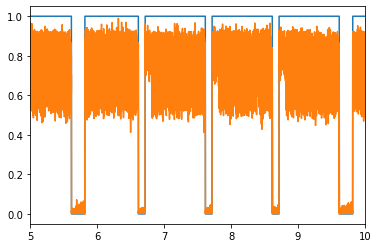

In [10]:
# apply schitt-trigger on the amplitude
st=schmitt(0.03, 0.05)

am_s=np.array([st.next(x) for x in amdemod])

plt.plot(t,am_s)
plt.plot(t,amdemod*10) # scale up for visibility

plt.xlim(5,10)
plt.show()


### Finding the start of a packet

We need to determine the start and end of of the modulated part of the time-pulse that contains the PSK information. That part is either 800 or 900 ms and starts when the AM-demodulated signal comes up.<br>
- If the timesignal information bit is '0', the carrier-amplitude is raised for 900 ms, including 100 ms block of unmodulated signal at the start
- If the timesignal information bit is '1', the carrier-amplitude is raised for only 800 ms

In [11]:
# detect changes in amplitude
edge=np.diff(am_s)
edgeup=np.where(edge == 1)[0]
edgedown=np.where(edge == -1)[0]

# the detector should start with an edge_up. If the first element of the detector output is a pulse-down, remove it from the list
if edgeup[0] > edgedown[0]: edgedown=edgedown[1:]

# the detector should end with an edge_dozn. If the last element of the detector output is a pulse-up, remove it from the list
if edgedown[-1] > edgedown[-1]: edgeup=edgeup[:-1]


packetboundaries=list(zip(edgeup,edgedown))

print(packetboundaries[:10]) # print up to the first 10 packets.

[(39145, 77525), (82349, 125525), (130344, 173524), (178344, 221524), (226339, 269525), (279142, 317524), (322338, 365526), (370341, 413524), (418343, 461525)]


## Inspecting the phase.

As we are interested in PSK, let's plot the phase of some of these packets. In this exercise, we'll look at packet number 0 and packet number 7.

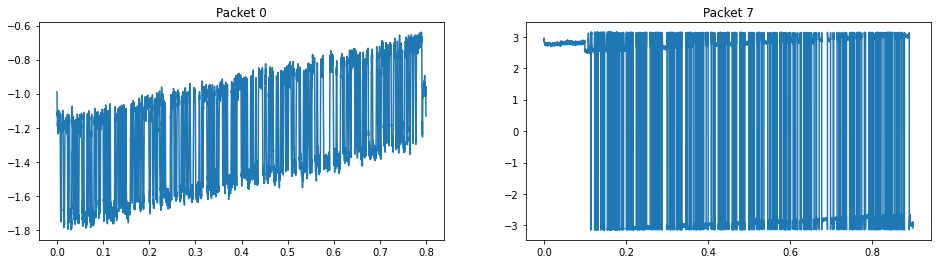

In [12]:
fig, axs = plt.subplots(1,2)

# plot phase of 1st packet
packetnumber=0

pstart,pend=packetboundaries[packetnumber]
l=pend-pstart # length
packet_t=np.linspace(0,l/samp_rate,l) # time axis
packet_ph=ph[pstart:pend]
axs[0].set_title("Packet 0")
axs[0].plot(packet_t,packet_ph)


# plot phase of 8th packet
packetnumber=7

pstart,pend=packetboundaries[packetnumber]
l=pend-pstart # length
packet_t=np.linspace(0,l/samp_rate,l) # time axis
packet_ph=ph[pstart:pend]
axs[1].set_title("Packet 7")
axs[1].plot(packet_t,packet_ph)

# figure size
fig.set_figwidth(16)
fig.set_figheight(4)

plt.show()


## Correcting the phase wrap-around

We will continue with packet number 7.<br>
In that packet, we see the phase wrap-around +pi and -pi radient. We correct this by 'unwrapping' the phase.<br>
The rule in this exercise is that, if a phase if below 0, it is assumed to be above the '+pi' line, so 2*pi is added.

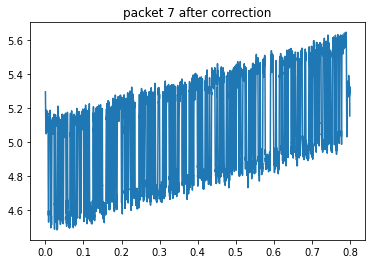

In [13]:
# plot phase of 8th packet .. with correction
packetnumber=0

pstart,pend=packetboundaries[packetnumber]
l=pend-pstart
packet_t=np.linspace(0,l/samp_rate,l)
packet_ph=ph[pstart:pend]
packet_phc=np.array([x if x > 0 else x + pi2 for x in packet_ph])
plt.plot(packet_t,packet_phc)
plt.title('packet 7 after correction')
plt.show()

## Some more cleanup: remove the unmodulated carrier (if present)

If a timesignal '0' is being transmitted, the carrier is AM modulated during 900 ms, but the first 100 ms does not carry any data.<br>
We will remove that part as it useless anyway and can only interfere with the FSK demodulator.

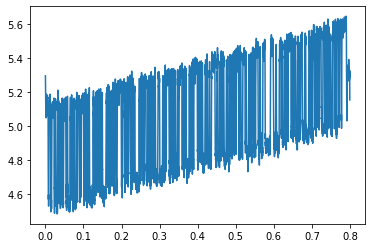

In [14]:
# strip 100 mt the beginning if the packet is a '0' databit.
if l > samp_rate * 0.85:
    packet_phc2=packet_phc[int(samp_rate*0.095):] # in fact, we remove just 95 ms; just to be safe.
    l=len(packet_phc2)
    packet_t=np.linspace(0,l/samp_rate,l)
else:
    packet_phc2=packet_phc

# plot the packet
plt.plot(packet_t,packet_phc2)
plt.show()


## Correcting the phase slope

Next step is to remove the constant slope. This is the result of a slight difference in frequency between the transmitter and the sender, even after applying the 'Downconvert to 0 Hz' step above.<br>
<br>
As the ramp is lineair, we can determine the angle of the slope by measuring of the graph at two marker-points: one the left side of the graph, the other on the right of the graph. Wo take the average of all the phase values 800 ms below and above every marker-point.<br>Marker 1 is at 150 ms, marker 2 is at 700 ms.

In [15]:
m1=l*1.5/8 # marker 1
m2=l*7/8 # marker 2
msize=l*0.8/8
avg1=packet_phc2[int(m1-msize):int(m1+msize)].mean()
avg2=packet_phc2[int(m2-msize):int(m2+msize)].mean()
print(avg1,avg2)

4.9109709913709345 5.256991256338097


### Now do some math

We now have this system of lineair equations:<br>
$a + \frac{1.5}{8} b = avg1$<br>
$a + \frac{7}{8} b = avg2$<br>
<br>
To solve it, as we are using numpy anyway, we can use numpy.linalg.solve to find a and b.<br>
<br>We need to transform this system of equations into two matrices and feed that to the numpy lineair algabra solver.
$\begin{bmatrix} 1 & \frac{1.5}{8}   \\ 1 & \frac{7}{8} \end{bmatrix}$ and $\begin{bmatrix} avg1 \\ avg2 \end{bmatrix}$<br>
The solver function returns the following matrix:  $\begin{bmatrix} a \\ b \end{bmatrix}$

In [16]:
a=np.array([ [1,m1],[1,m2]])
b=np.array([avg1,avg2])
a1,a2=np.linalg.solve(a,b)

# print the solution of the system of lineair equation
print(a1,a2)


4.816601828198072 1.3113658248791025e-05


In [17]:
### to verify, recalculate the markerpoints
print(avg1,avg2)
print(a1+a2*m1,a1+a2*m2)

4.9109709913709345 5.256991256338097
4.9109709913709345 5.256991256338097


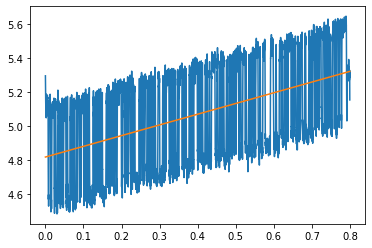

In [18]:
# plot the packet and the slope

avgline=np.linspace(a1,a1+l*a2,l)

plt.plot(packet_t,packet_phc2)
plt.plot(packet_t,avgline)

plt.show()

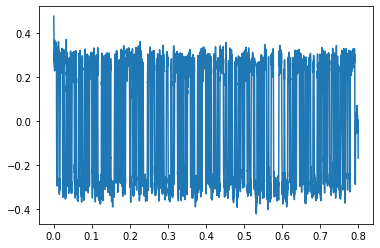

In [19]:
packet_phc3=packet_phc2-avgline
plt.plot(packet_t,packet_phc3)
plt.show()

# Part 4: PSK demodulation

## Downsample 

To reduce the amount of data to process, let's downsample the signal to 16 ksps.

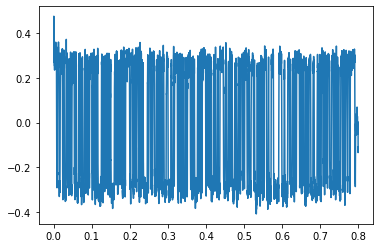

In [20]:
decim=3 # 48k to 16 k
packet16k=scipy.signal.resample_poly(packet_phc3,1,decim)
l=len(packet16k)

samp_rate_2=int(samp_rate/decim)
packet_t16k=np.linspace(0,l/samp_rate_2,l)

plt.plot(packet_t16k,packet16k)
plt.show()

## Signal cleanup

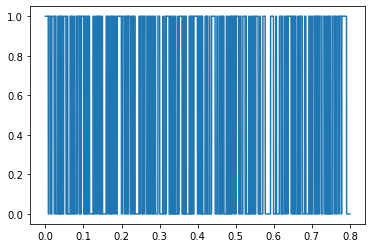

In [21]:
# apply schmitt-trigger on packet
st2=schmitt(-0.1, 0.1)

packet_s=np.array([st2.next(x) for x in packet16k])

plt.plot(packet_t16k,packet_s)
plt.show()


## Clock syncronisation

The PSK signal is 512 bits in 793 ms. At 16000 samples/second, that is 24.781 samples per symbol. <br>
Convolute "sps" 1's on the signal to detect the symbol boundaries.<br>
<br>
Plot the complete packet and zoom in.

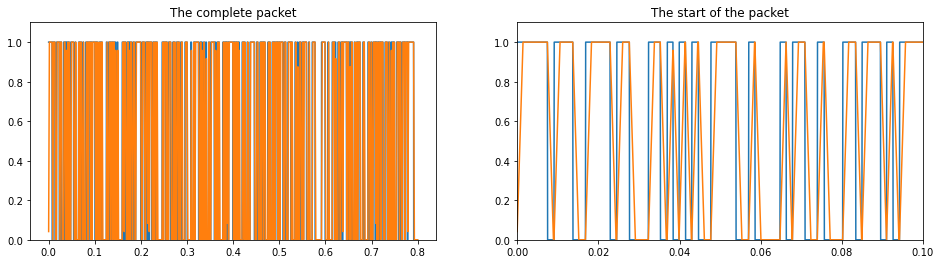

In [22]:
sps=samp_rate_2*0.793/512
sps_i=int(sps)

bits1=np.ones(sps_i)

packet_c=np.convolve(packet_s, bits1)[:l]/sps_i
fig, axs = plt.subplots(1,2)

axs[0].plot(packet_t16k,packet_s)
axs[0].plot(packet_t16k,packet_c)
axs[0].set_ylim(0,1.1)
axs[0].set_title("The complete packet")

axs[1].plot(packet_t16k,packet_s)
axs[1].plot(packet_t16k,packet_c)
axs[1].set_xlim(0,0.1)
axs[1].set_ylim(0,1.1)
axs[1].set_title("The start of the packet")

fig.set_figwidth(16)
fig.set_figheight(4)
plt.show()



## Detect the exact start of the packet.

As a packet can start with a number '0' bits, which are difficult to detect, we need some other way to detect the start of the packet.<br>
As, in fact, these leading '0's have become hidden due to the schmitt-trigger cleanup action above, we'll look at the start of the packet combined with the original packet phase information.

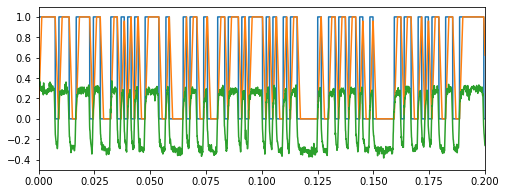

In [23]:
fig=plt.figure()
plt.plot(packet_t16k,packet_s)
plt.plot(packet_t16k,packet_c)
plt.plot(packet_t16k,packet16k)
plt.ylim(-0.5,1.1)
plt.xlim(0,0.2)

fig.set_figwidth(8)
fig.set_figheight(3)
plt.show()



The packet starts when the phase of the signal goes below 0. In this exercise, we will set the "start-of-packet" trigger at -0.2<br>

In [24]:
packetstart=np.where(abs(packet16k)>0.2)[0][0]

## Do PSK demodulation

The PSK demodulator below uses a algorythm losely based on the M&M clock recovery; then print the result.<br>
<br>
Change "printdebug" in the code for additional debugging

In [25]:
l = len(packet_c) - sps_i # length of packet, subtrack "sps" for last bit
p = packetstart # start of data

received=[]


printdebug=False # change this to enable debugging


while p < l:
        pr=round(p)
        # find end of bit first, then get data
        # the end-of-bit is 12 samples further, so get samples 18,19,20,21,22 
        c=packet_c[pr+sps_i-2:pr+sps_i+3]

        lower=c[0]+c[1]
        mid=c[2]
        higher=c[3]+c[4]

        prevp=p

        # above the zero-line
        if (lower == higher):
                # ad3 is in balance, move up 40 samples for 1 bit
                p+=sps
        elif (lower > higher):
                if mid > 0.5:
                        p+=(sps-1)
                else:
                        # mid < 0.5
                        p+=(sps+1)
                #end if
        else:
                # higer > lower
                if mid > 0.5:
                        p+=(sps+1)
                else:
                        # mid < 0.5
                        p+=(sps-1)
                #end if
        #end if 

        # p has already been moved up by sps-1, sps or sps+#),
        #    so subtrack half a bit (sps2 samples) to get the correct value
        v = round(packet_c[pr-sps_i])

        received.append(v)

        if printdebug: print("{v} {p:5.2f} [{c0:1.2f},{c1:1.2f},{c2:1.2f},{c3:1.2f},{c4:1.2f}]".format(v=v,p=p,c0=c[0],c1=c[1],c2=c[2],c3=c[3],c4=c[4]))

#end while





In [26]:
r=np.array(received)
print(r)

[0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0
 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0
 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0
 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1
 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0
 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1
 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 0
 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0
 1 0 1 0 1 0 0 0 1 1 1 0 

# Part 6: Verify the received information.

The PSK-modulated signal is a fixed predefined pseudo-random bitpattern, as defined by the specification found in the reference documents. So we need to compare the PSK bits we received with the bitpattern we expect to see.<br>
<br>
## Calculate the PSK sequence

In [27]:
pskbits=[]

lfsr = 0

for _ in range(512):
        chip = lfsr & 1
        pskbits.append(1 if chip > 0 else 0)
        lfsr >>= 1
        if (chip > 0 ) or (lfsr == 0): lfsr ^= 0x110
#end for

pskbits=np.array(pskbits)

In [28]:
print(pskbits)


[0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1
 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0
 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0
 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1
 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1
 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1
 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1
 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1
 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0
 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0
 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 1
 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1
 0 1 0 1 1 1 0 0 0 1 0 0 

### Compaire

The received PSK signal is a bit longer then the exptected signal.<br>
When we remove the first 2 and the last 2 bits of the received bits. we do seems to have a bitpattern that looks similar to the expected PSK pattern, but let's do the full check anyway

In [29]:
for i in range(len(r)-512+1):
    check1=np.equal(r[i:i+512],pskbits)
    check2=np.not_equal(r[i:i+512],pskbits)
    
    if check1.all():
        print("YES! full match after shift of",i)
        break
    elif check2.all():
        print("YES! inverted match after shift of",i)
        break
    #end elif - if
else:
    print("NOT GOOD :-( ")
#end else - for


YES! inverted match after shift of 2
